In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest
from pandas_profiling import ProfileReport
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor
%matplotlib inline

In [2]:
data = pd.read_csv('1111.csv', parse_dates=True)

In [3]:
data.head(10)

,Скважина,Дата,ГТМ,Метод,Характер работы,Состояние,"Время работы, ч",Время накопления,"Нефть, т","Попутный газ, м3",...,Пластовое давление начальное,Характеристический дебит жидкости,Время в работе,Время в накоплении,ГП - Забойное давление,ГП(ИДН) Дебит жидкости,ГП(ИДН) Дебит жидкости скорр-ый,ГП(ИДН) Прирост дефита нефти,ГП(ГРП) Дебит жидкости,ГП(ГРП) Дебит жидкости скорр-ый
0,53514b4c4150ad897d82dd7d42cfc1a5,2012-03-30,0.0,ЭЦН/ФОН,НЕФ,РАБ.,301.0,0.0,"278,55",10028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53514b4c4150ad897d82dd7d42cfc1a5,2012-04-30,0.0,ЭЦН,НЕФ,РАБ.,720.0,0.0,"1074,74",38690.0,...,231.0,847.308443,0.0,0.0,35.0,96.493251,96.493251,6.061904,363.692491,363.692491
2,53514b4c4150ad897d82dd7d42cfc1a5,2012-05-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,"1046,80",37685.0,...,231.0,590.462454,0.0,0.0,36.0,65.665158,65.665158,1.483960,272.727847,272.727847
3,53514b4c4150ad897d82dd7d42cfc1a5,2012-06-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,"900,95",32434.0,...,231.0,644.968860,0.0,0.0,35.4,53.838648,53.838648,0.510737,218.225582,218.225582
4,53514b4c4150ad897d82dd7d42cfc1a5,2012-07-31,0.0,ЭЦН,НЕФ,РАБ.,720.0,0.0,"761,72",27422.0,...,231.0,583.248775,0.0,0.0,37.6,47.981737,47.981737,0.640583,199.966616,199.966616
5,53514b4c4150ad897d82dd7d42cfc1a5,2012-08-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,"651,91",23469.0,...,231.0,520.097122,0.0,0.0,36.0,43.254470,43.254470,0.774886,186.179638,186.179638
6,fe017a547ac58cc7366a60cc6bcd3915,2013-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,231.0,173.810175,0.0,0.0,25.1,19.799452,19.799452,0.041206,133.389671,133.389671
7,fe017a547ac58cc7366a60cc6bcd3915,2013-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,231.0,568.878505,0.0,0.0,24.6,192.617527,192.617527,21.096702,311.863817,311.863817
8,fe017a547ac58cc7366a60cc6bcd3915,2013-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,231.0,347.974256,0.0,0.0,25.5,125.434716,125.434716,16.821978,235.601328,235.601328
9,fe017a547ac58cc7366a60cc6bcd3915,2013-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,231.0,282.847200,0.0,0.0,25.7,101.963632,101.963632,12.802601,203.642833,203.642833


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Columns: 115 entries, Скважина to ГП(ГРП) Дебит жидкости скорр-ый
dtypes: float64(82), object(33)
memory usage: 2.9+ MB


**Целью исследования является построение регрессионной модели, прогнозирующей переменную 'Нефть, т'**  
В рамках построения модели выделим следующие этапы:
1. Очистка данных:  
    а. записи с отсутствующими значениями прогнозируемой переменной  
    б. удалить константные признаки  
    в. удалить коллинеарные признаки  
2. Разведочный анализ данных:  
    а. построение графиков  
    б. заполнение пропусков в данных  
3. Построение тестовой модели и отбор признаков
4. Построение новых признаков
5. Моделирование и выбор оптимальной модели
6. Интерпретация модели
7. Заключение

# Очистка данных

Проанализируем наличие отсутствующих значение в прогнозируемой переменной 'Нефть, т'. В случае наличия пропусков удалим эти записи из набора данных

In [5]:
data["Нефть, т"] = data["Нефть, т"].str.replace(",",".").astype(float)
sum(np.isnan(data["Нефть, т"]))

461

461 запись из 3357 не содержит значения прогнозируемой переменной

In [6]:
data = data[np.isfinite(data["Нефть, т"])]

In [7]:
data = data.reset_index(drop=True)

Преобразуем некоторые атрибуты к корректному типу данных

In [8]:
data["Дата"] = pd.to_datetime(data["Дата"])

In [9]:
data["Обводненность (вес), %"] = data["Обводненность (вес), %"].str.replace(",",".").astype(float)
data["Приемистость, м3/сут"] = data["Приемистость, м3/сут"].str.replace(",",".").astype(float)
data["Добыча растворенного газа, м3"] = data["Добыча растворенного газа, м3"].str.replace(",",".").astype(float)
data["Дебит попутного газа, м3/сут"] = data["Дебит попутного газа, м3/сут"].str.replace(",",".").astype(float)
data["Конденсат, т"] = data["Конденсат, т"].str.replace(",",".").astype(float)
data["Дебит конденсата"] = data["Дебит конденсата"].str.replace(",",".").astype(float)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Columns: 115 entries, Скважина to ГП(ГРП) Дебит жидкости скорр-ый
dtypes: datetime64[ns](1), float64(89), object(25)
memory usage: 2.5+ MB


Проанализируем полноту и целостность данных с использованием инструмента pandas-profiling.  
Данный инструмент выполняет комплексный анализ данных на предмет пропусков, поиска константных и коллинеарных признаков

In [11]:
profile = ProfileReport(data)

In [12]:
rejected_vars = profile.get_rejected_variables()

In [13]:
rejected_vars

['Вязкость жидкости в пласт. условиях',
 'ГП(ГРП) Дебит жидкости',
 'ГП(ГРП) Дебит жидкости скорр-ый',
 'ГП(ИДН) Дебит жидкости',
 'ГП(ИДН) Дебит жидкости скорр-ый',
 'Глубина спуска доп. оборудования',
 'Дата ввода в эксплуатацию',
 'Дата запуска после КРС',
 'Дата останова',
 'Дата пуска',
 'Дебит попутного газа, м3/сут',
 'Добыча растворенного газа, м3',
 'Плотность нефти']

Признак 'Причина простоя' содержит дубликаты значений, записанные в разных регистрах, необходимо привести значения к единому знаменателю

In [14]:
data['Причина простоя'].unique()

array([nan, 'Освоение после бурения', 'Геологич.причина',
       'Ввод новой скважины', 'Ремонт запорной арматуры', 'Прочие', 'ГРП',
       'Нет подачи', 'Ремонт назем.электрообор.', 'Заклинивание насос',
       'Принята в освоение', 'ПРИНЯТА В ОСВОЕНИЕ',
       'ОЖИДАН.КАПИТАЛ.РЕМОНТА', 'НЕТ ПРИЕМИСТОСТИ', 'Недогрузка',
       'Отключение напряжения', 'Недоосвоена после ПРС',
       'Замена СУ на ЧП', 'Прочие aвaрии', 'Дисбаланс напряжения',
       'Заморожен коллектор', 'Технолог.причина', 'R=0',
       'Останов по распоряжен.', 'Перевод в ППД', 'Техническ.причина',
       'Сменa НКТ из-зa негермет.', 'Ремонт соседней скважина',
       'Неисправ.глуб.оборуд.', 'Нет приемистости',
       'Ревиз.подзем.оборудования', 'Перевод скв.в другой фонд',
       'Отсутствие связи с ТМС', 'Пропaркa фонтaн.aрмaтуры', 'СКО пласта',
       'ОСВОЕНИЕ ПОСЛЕ БУРЕНИЯ', 'ОТКЛЮЧЕНИЕ ФИДЕРА', 'ПЕРЕВОД В ППД',
       'НЕИСПРАВНОСТЬ СУ, ЧП'], dtype=object)

In [15]:
duplicates = {"ОСВОЕНИЕ ПОСЛЕ БУРЕНИЯ": "Освоение после бурения",
             "ПРИНЯТА В ОСВОЕНИЕ": "Принята в освоение",
             "НЕТ ПРИЕМИСТОСТИ": "Нет приемистости",
             "ПЕРЕВОД В ППД" : "Перевод в ППД"}

In [16]:
for key, value in duplicates.items():
    data.loc[data["Причина простоя"] == key,"Причина простоя"] = value

In [17]:
data['Причина простоя'].unique()

array([nan, 'Освоение после бурения', 'Геологич.причина',
       'Ввод новой скважины', 'Ремонт запорной арматуры', 'Прочие', 'ГРП',
       'Нет подачи', 'Ремонт назем.электрообор.', 'Заклинивание насос',
       'Принята в освоение', 'ОЖИДАН.КАПИТАЛ.РЕМОНТА', 'Нет приемистости',
       'Недогрузка', 'Отключение напряжения', 'Недоосвоена после ПРС',
       'Замена СУ на ЧП', 'Прочие aвaрии', 'Дисбаланс напряжения',
       'Заморожен коллектор', 'Технолог.причина', 'R=0',
       'Останов по распоряжен.', 'Перевод в ППД', 'Техническ.причина',
       'Сменa НКТ из-зa негермет.', 'Ремонт соседней скважина',
       'Неисправ.глуб.оборуд.', 'Ревиз.подзем.оборудования',
       'Перевод скв.в другой фонд', 'Отсутствие связи с ТМС',
       'Пропaркa фонтaн.aрмaтуры', 'СКО пласта', 'ОТКЛЮЧЕНИЕ ФИДЕРА',
       'НЕИСПРАВНОСТЬ СУ, ЧП'], dtype=object)

Удалим из набора данных константные и коллинеарные признаки

In [18]:
data = data.drop(columns=rejected_vars)
data = data.drop(columns=['Конденсат, т', 'Дебит конденсата', 'Фирма ГРП', 'Тип газосепаратора', 'Станок-качалка', 'Природный газ, м3', 'Газ из газовой шапки, м3',
                          'Коэффициент сепарации', 'Вязкость воды в пластовых условиях', 'Радиус контура питания', 'Фонтан через насос', 'Число качаний ШГН',
                         'Длина хода плунжера ШГН', 'Диаметр плунжера', 'Коэффициент подачи насоса', 'КН закрепленный'])

In [23]:
data.to_csv('clean1.csv', index=False)

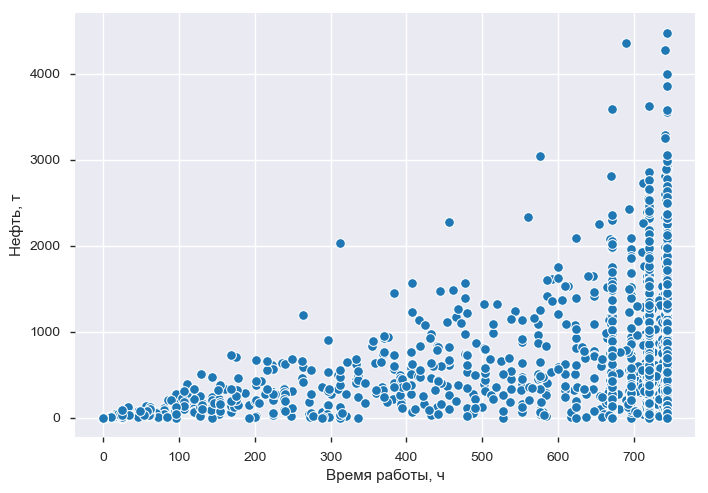

In [114]:
sns.scatterplot(x = 'Время работы, ч', y=target, data = data)

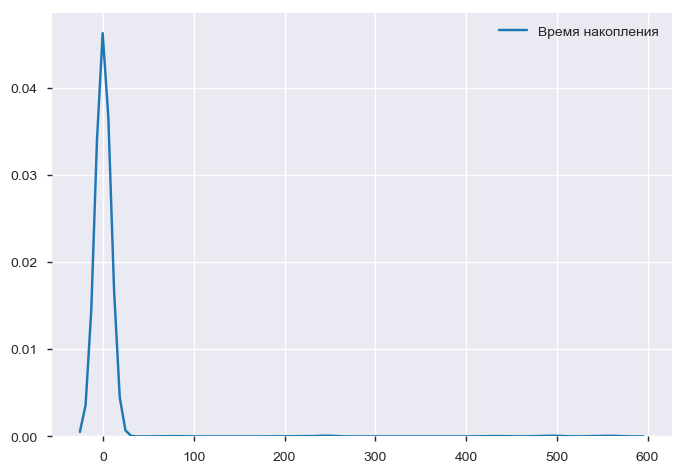

In [112]:
sns.scatterplot(x = 'Время работы, ч', y=target, data = data)

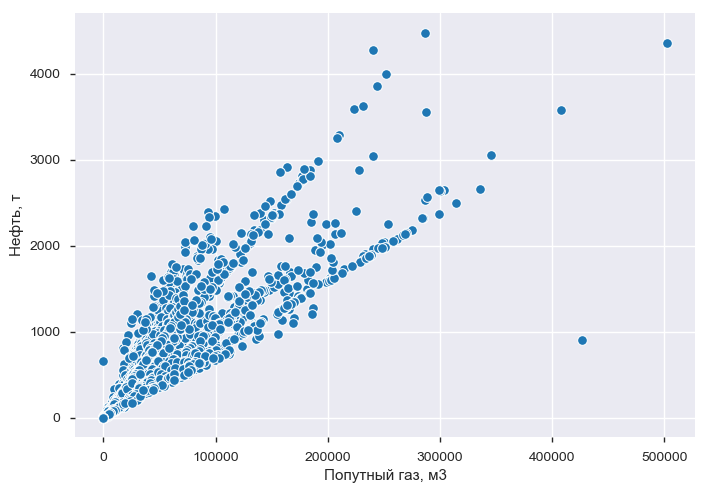

In [115]:
sns.scatterplot(x = 'Попутный газ, м3', y=target, data = data)

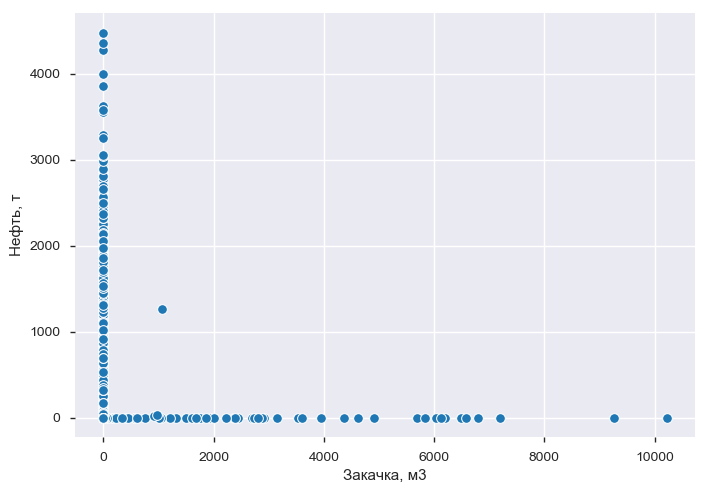

In [120]:
sns.scatterplot(x = 'Закачка, м3', y=target, data = data)
#data['Закачка, м3'].hist()
# !!! вероятно когда была закачка - добыча на нуле? Проверить!!!

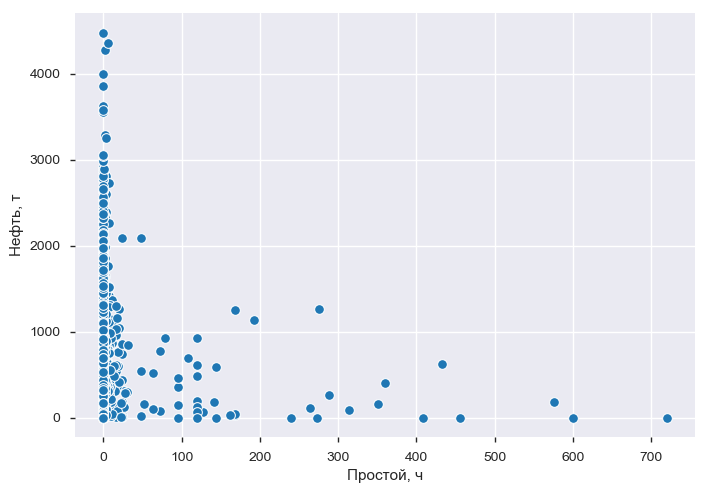

In [34]:
sns.scatterplot(x = 'Простой, ч', y='Нефть, т', data = data)
#data['Простой, ч'].hist()
#!!! Возможно стоит ввести бинарный признак наличия простоя

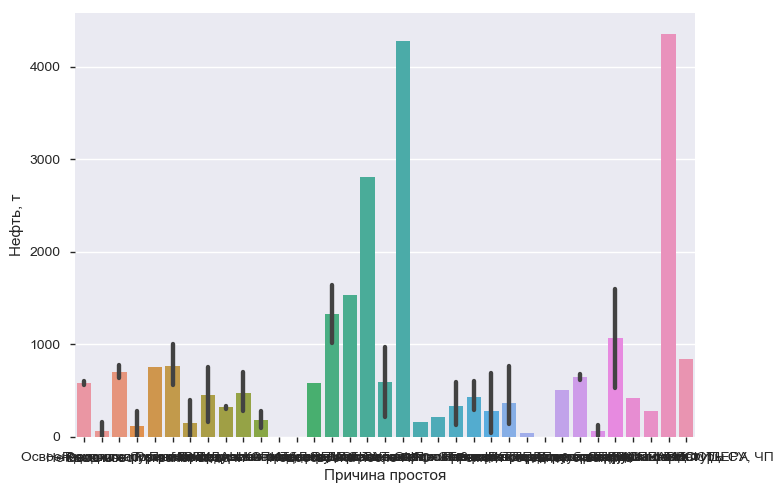

In [133]:
sns.barplot(x = 'Причина простоя', y=target, data = data)
# Проанализировать как причина простоя связана с предыдущим параметром

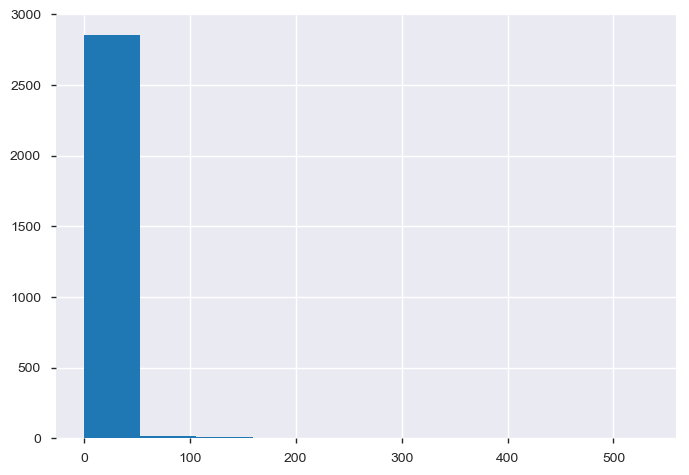

In [137]:
#sns.scatterplot(x = 'Приемистость, м3/сут', y=target, data = data) # при ненулевых значениях приемистости наблюдаются нулевые значения добычи, возможно из-за пропусков
data['Приемистость, м3/сут'].hist()

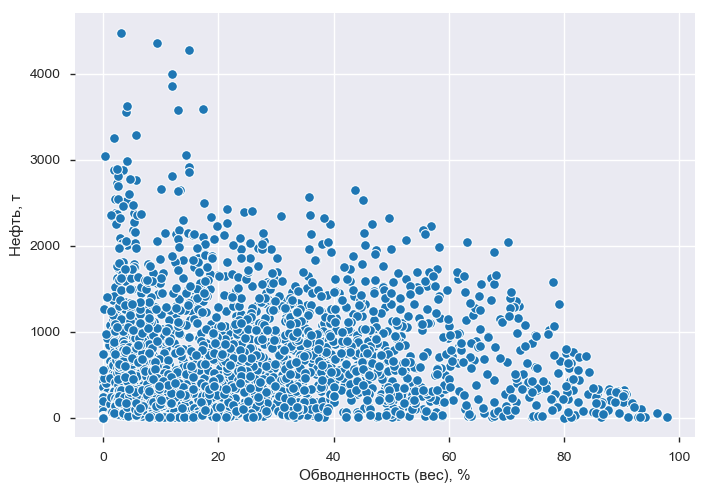

In [139]:
sns.scatterplot(x = 'Обводненность (вес), %', y=target, data = data)
#data['Обводненность (вес), %'].hist()

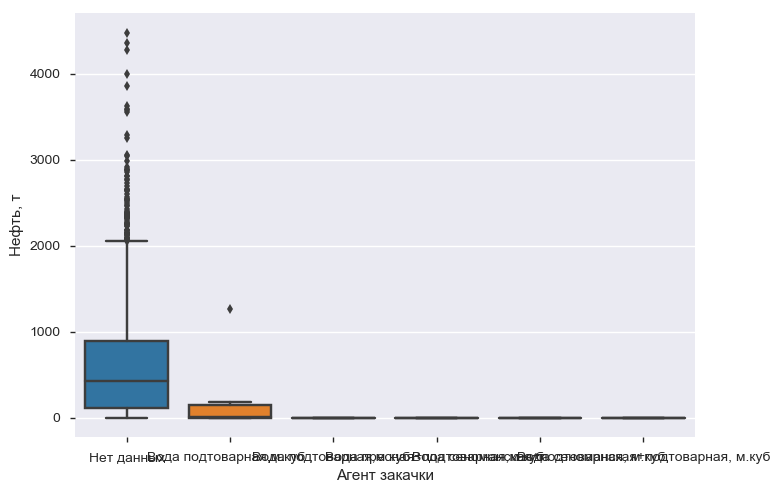

In [140]:
sns.boxplot(data['Агент закачки'], target)

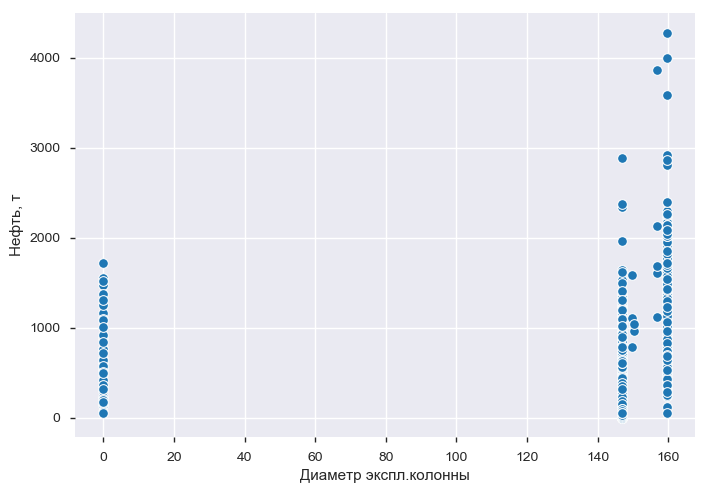

In [142]:
sns.scatterplot(x = 'Диаметр экспл.колонны', y=target, data = data) # !!! Необходимо проанализировать какие признаки могут определять для заполнения по правилам
#data['Диаметр экспл.колонны'].hist()

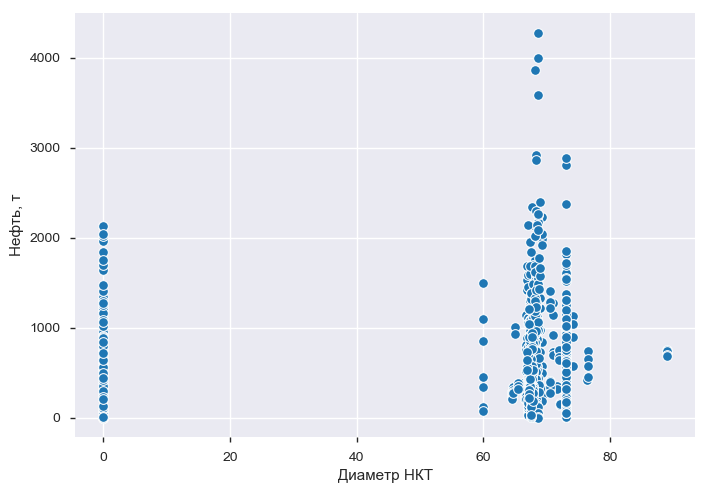

In [143]:
sns.scatterplot(x = 'Диаметр НКТ', y=target, data = data) # !!! Необходимо проанализировать какие признаки могут определять для заполнения по правилам
#data['Диаметр НКТ'].hist()

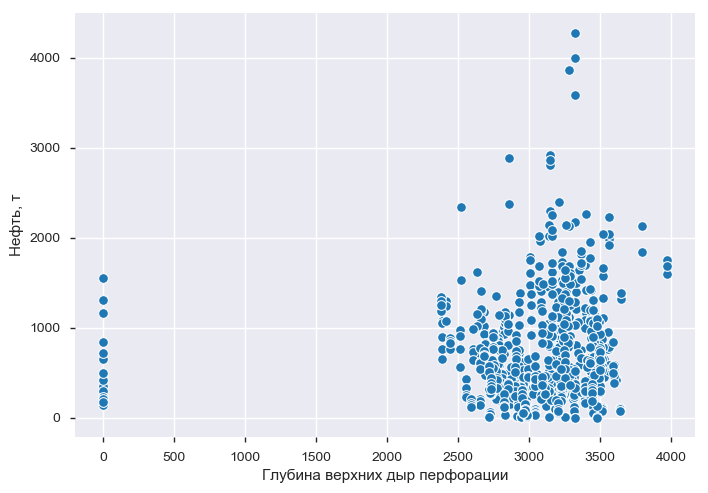

In [36]:
#sns.scatterplot(x = 'Глубина верхних дыр перфорации', y=target, data = data)
#data['Глубина верхних дыр перфорации'].hist()
sns.scatterplot(x='Глубина верхних дыр перфорации', y='Нефть, т', data=data)
#Проанализировать 0, посмотреть могу ли заполнить медианным значением

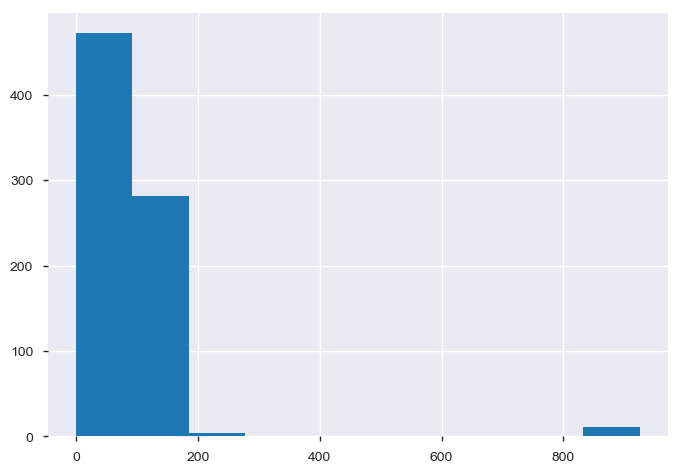

In [151]:
#sns.scatterplot(x = 'Производительность ЭЦН', y=target, data = data) # можно ли заполнить нулями?
data['Производительность ЭЦН'].hist()

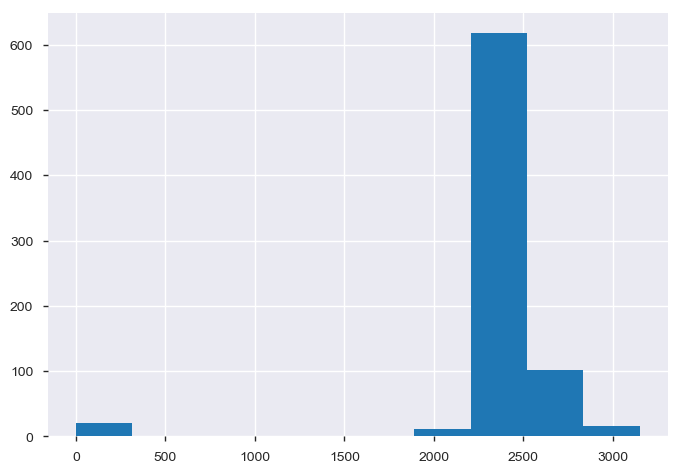

In [156]:
#sns.scatterplot(x = 'Напор', y=target, data = data) # выявить когда встречаются нули? для каких типов скважин наблюдается добыча при нулевом напоре?
data['Напор'].hist()

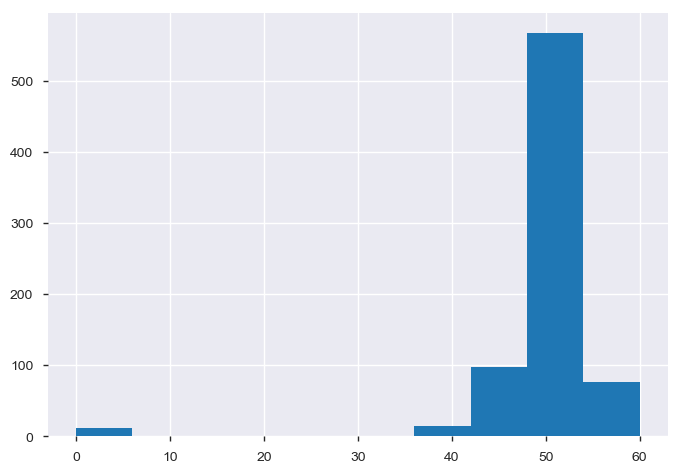

In [160]:
#sns.scatterplot(x = 'Частота', y=target, data = data)
data['Частота'].hist() # проанализировать аналогично предыдущему

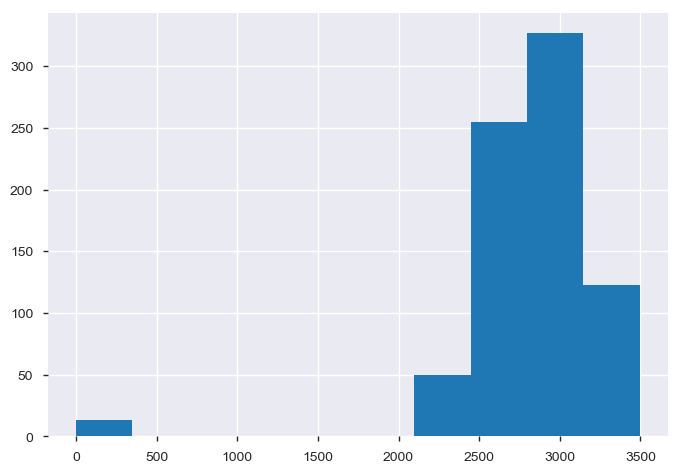

In [165]:
#sns.scatterplot(x = 'Глубина спуска', y=target, data = data)
data['Глубина спуска'].hist() # аналогично - проверить нули

20.0

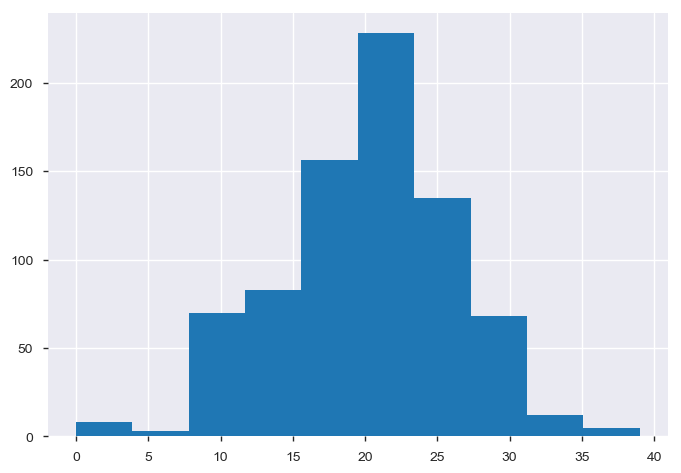

In [169]:
#sns.scatterplot(x = 'Буферное давление', y=target, data = data)
data['Буферное давление'].hist() # заполнить медианой, но проверить на зависимость с другими признаками (возможно корреляция с другим признаком)
data['Буферное давление'].median()

19.0

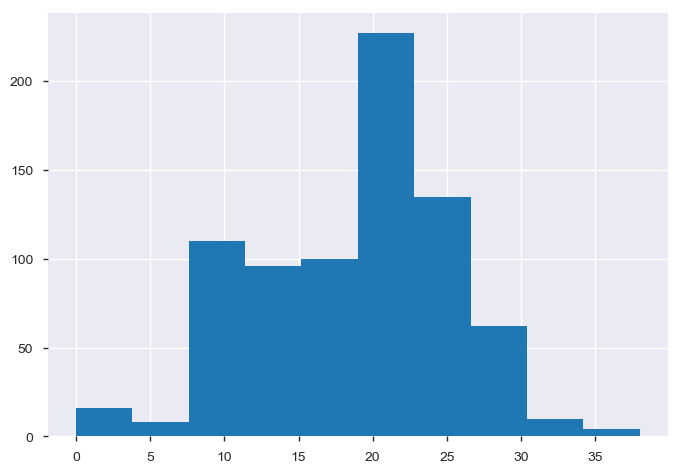

In [171]:
#sns.scatterplot(x = 'Буферное давление', y=target, data = data)
data['Давление в линии'].hist() # заполнить медианой, но проверить на зависимость с другими признаками (возможно корреляция с другим признаком)
data['Давление в линии'].median()

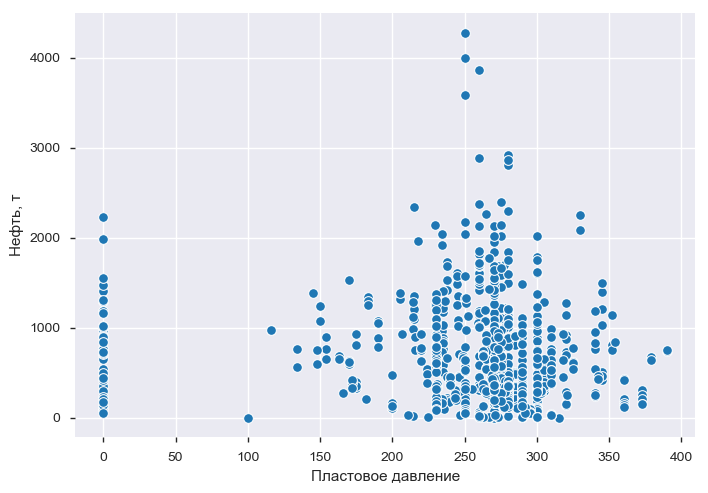

In [173]:
sns.scatterplot(x = 'Пластовое давление', y=target, data = data)
#data['Пластовое давление'].hist() # заполнить медианой, но проверить нули
#data['Давление в линии'].median()

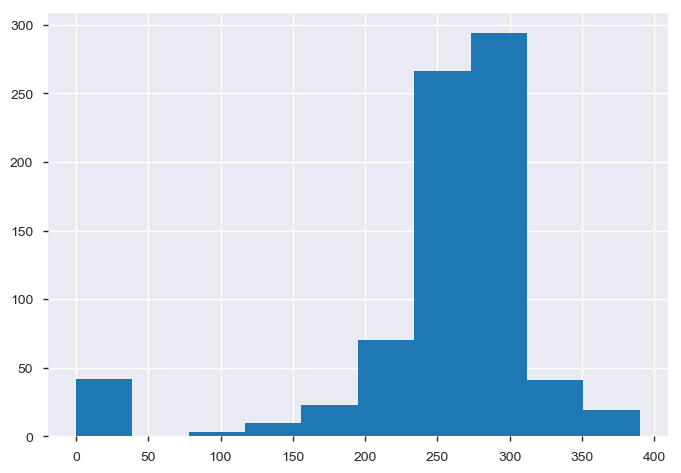

In [175]:
#sns.scatterplot(x = 'Динамическая высота', y=target, data = data)
data['Пластовое давление'].hist() # заполнить медианой, но проверить нули

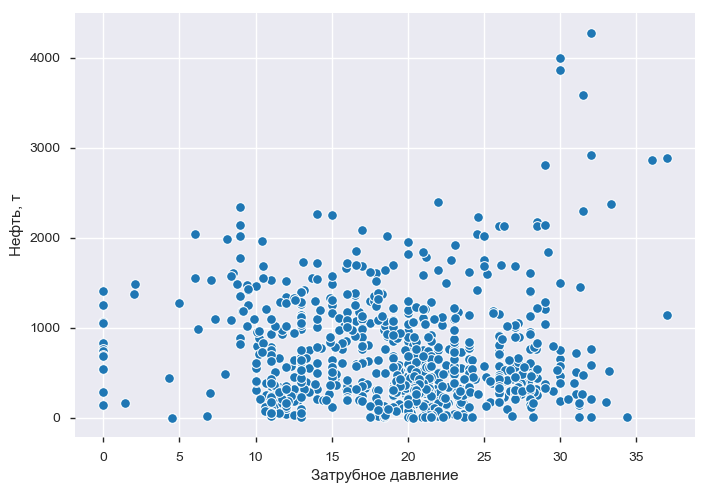

In [178]:
sns.scatterplot(x = 'Затрубное давление', y=target, data = data)
#data['Затрубное давление'].hist() # заполнить медианой

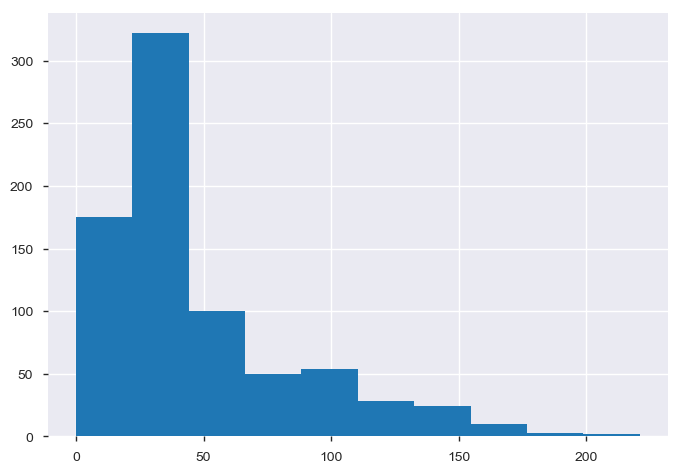

In [181]:
#sns.scatterplot(x = 'Давление на приеме', y=target, data = data)
data['Давление на приеме'].hist() 

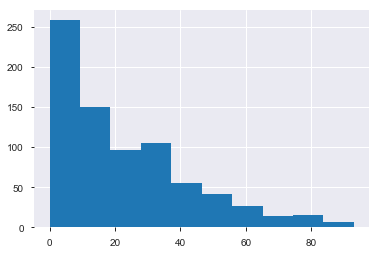

In [210]:
#sns.scatterplot(x = 'Обводненность', y=target, data = data)
data['Обводненность'].hist() 

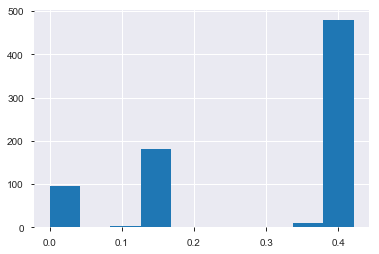

In [225]:
#sns.scatterplot(x = 'JD факт', y=target, data = data)
data['JD факт'].hist() # 3 кластера явно, как их обработать???

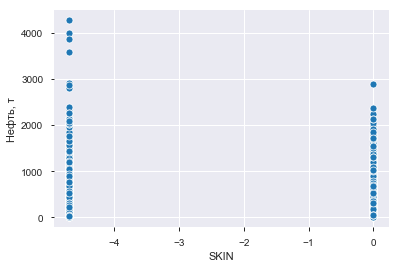

In [226]:
sns.scatterplot(x = 'SKIN', y=target, data = data)
#data['Температура пласта'].hist() # Проверить какие признаки влияют

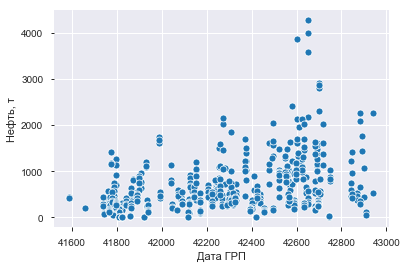

In [227]:
sns.scatterplot(x = 'Дата ГРП', y=target, data = data)
#data['Температура пласта'].hist() # ???

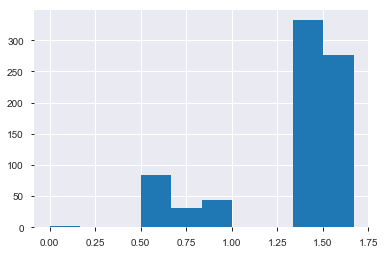

In [230]:
#sns.scatterplot(x = 'Вязкость нефти в пластовых условиях', y=target, data = data)
data['Вязкость нефти в пластовых условиях'].hist() # ???

array([  nan, 1.12 , 1.233, 1.35 , 1.144, 1.34 ])

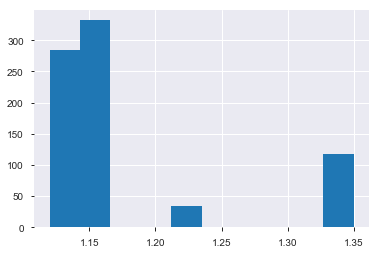

In [233]:
#sns.scatterplot(x = 'Вязкость нефти в пластовых условиях', y=target, data = data)
data['объемный коэффициент'].hist() # ???
data['объемный коэффициент'].unique()

array([  nan, 1.03 , 1.011, 1.   , 1.009, 1.015, 1.003, 1.019, 1.02 ])

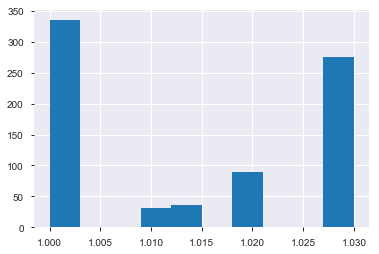

In [234]:
#sns.scatterplot(x = 'Вязкость нефти в пластовых условиях', y=target, data = data)
data['Плотность воды'].hist() # ???
data['Плотность воды'].unique()

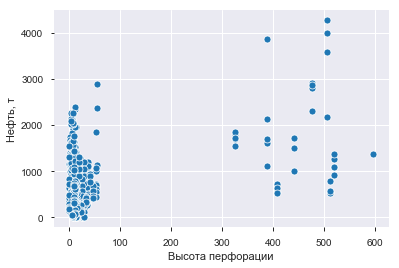

In [237]:
sns.scatterplot(x = 'Высота перфорации', y=target, data = data)
#data['Высота перфорации'].hist() # проанализировать ненулевые значения
#data['Высота перфорации'].unique()

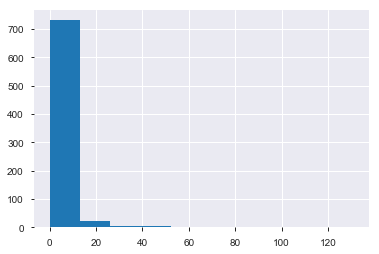

In [238]:
#sns.scatterplot(x = 'Удельный коэффициент', y=target, data = data)
data['Удельный коэффициент'].hist() # проанализировать ненулевые значения

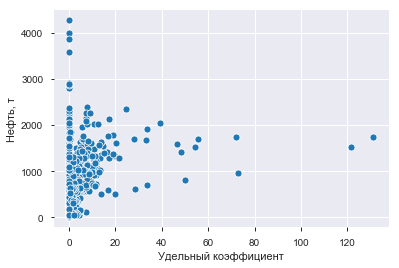

In [240]:
sns.scatterplot(x = 'Удельный коэффициент', y=target, data = data)
#data['Коэффициент продуктивности'].hist()

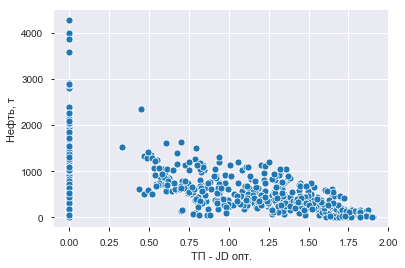

In [245]:
sns.scatterplot(x = 'ТП - JD опт.', y=target, data = data) # проанализировать нули, есть явная линейная зависимость
#data['ТП - JD опт.'].hist()

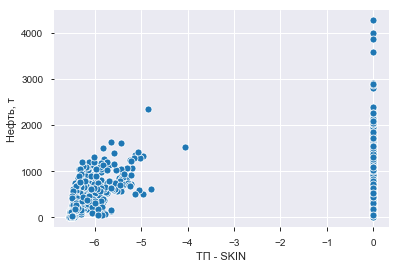

In [247]:
sns.scatterplot(x = 'ТП - SKIN', y=target, data = data) # проанализировать нули, есть явная линейная зависимость
#data['ТП - JD опт.'].hist()

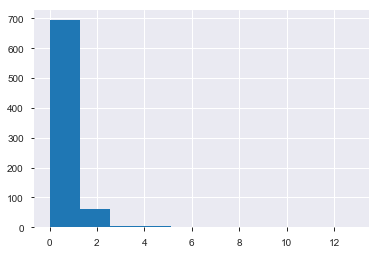

In [250]:
#sns.scatterplot(x = 'К пр от стимуляции', y=target, data = data) # пуассон?
data['К пр от стимуляции'].hist()

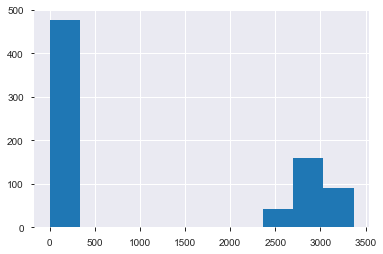

In [251]:
#sns.scatterplot(x = 'К пр от стимуляции', y=target, data = data) # нули!
data['Глубина спуска.1'].hist()

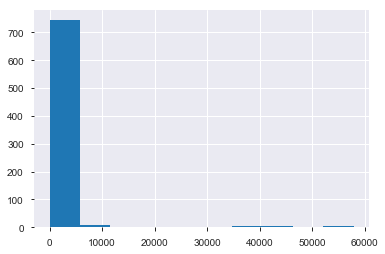

In [254]:
#sns.scatterplot(x = 'Время до псевдоуст-ся режима', y=target, data = data) # проанализировать ненулевые значения
data['Время до псевдоуст-ся режима'].hist()

array([      nan, 6.000e+00, 1.270e+01, 0.000e+00, 3.600e+00, 8.800e+00,
       1.080e+01, 5.865e+02, 1.900e+01, 1.420e+01, 5.800e+00, 7.800e+00,
       8.200e+00, 1.040e+01, 9.200e+00, 6.400e+00, 4.600e+00, 1.200e+01,
       3.200e+00, 2.600e+00, 4.800e+00, 1.600e+00, 5.000e+00, 3.100e+00,
       3.400e+00, 9.000e+00, 7.000e+00, 1.070e+01, 1.580e+01, 9.600e+00,
       1.980e+01, 3.800e+00, 4.500e+00, 5.600e+00, 1.320e+01, 1.480e+01,
       1.540e+01, 7.400e+00, 1.000e+00, 8.600e+00, 1.440e+01, 8.900e+00,
       1.340e+01, 9.800e+00, 1.260e+01, 1.500e+01, 7.600e+00, 4.480e+00,
       2.600e+01, 5.200e+00, 1.240e+01, 6.200e+00, 4.000e+00, 1.100e+01,
       1.400e+01, 9.710e+00, 4.000e-01, 2.300e+01, 3.000e+00, 3.460e+01,
       1.460e+01, 2.380e+01, 1.780e+01, 1.850e+01, 1.600e+01, 1.510e+01,
       1.140e+01, 1.430e+01, 1.410e+01, 2.210e+01, 1.560e+01, 5.400e+00,
       6.600e+00, 6.100e+00, 1.000e-01, 8.300e+00, 1.120e+01, 8.000e+00,
       1.300e+01, 2.140e+01, 1.960e+01, 1.800e+01, 

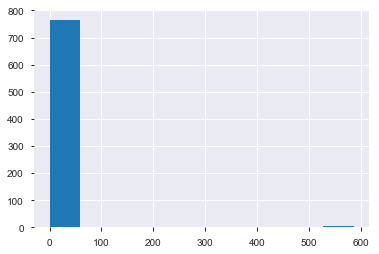

In [263]:
#sns.scatterplot(x = 'Замерное забойное давление', y=target, data = data) # есть явный выброс???
data['Нефтенасыщенная толщина'].hist()
data['Нефтенасыщенная толщина'].unique()

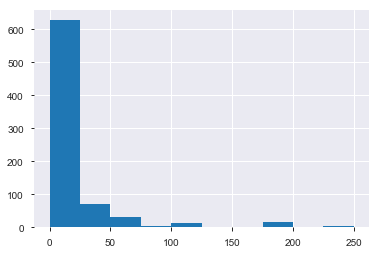

In [270]:
#sns.scatterplot(x = 'Замерное забойное давление', y=target, data = data) # проанализировать с маркой ПЭД
data['Мощность ПЭД'].hist()

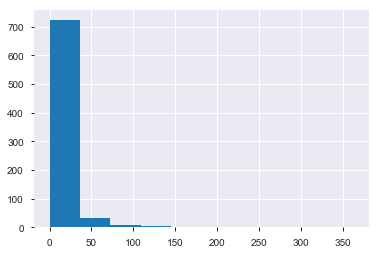

In [287]:
#sns.scatterplot(x = 'ГП - Забойное давление', y=target, data = data) # проанализировать с маркой ПЭД
data['ГП(ИДН) Прирост дефита нефти'].hist()

In [206]:
num_features = np.where(data.dtypes == 'float')
for i in num_features:
    print(kstest(data.iloc[:, i], 'norm'))

(2896, 70)


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 97 columns):
Скважина                                2896 non-null object
Дата                                    2896 non-null datetime64[ns]
ГТМ                                     2896 non-null float64
Метод                                   2813 non-null object
Характер работы                         2888 non-null object
Состояние                               2887 non-null object
Время работы, ч                         2896 non-null float64
Время накопления                        2896 non-null float64
Нефть, т                                2896 non-null float64
Попутный газ, м3                        2896 non-null float64
Закачка, м3                             2896 non-null float64
Природный газ, м3                       2896 non-null float64
Газ из газовой шапки, м3                2896 non-null float64
Простой, ч                              2896 non-null float64
Причина простоя       

In [80]:
target = data['Нефть, т']
data = data.drop(columns=['Нефть, т', 'Дата'])

Попробуем построить регрессионную модель 'как есть' с использованим алгоритма градиентный бустинг в пакетах CatBoost и LightGBM

In [81]:
cat_features_indices = np.where(data.dtypes == 'object')[0]

In [82]:
cat_features_indices

array([ 0,  2,  3,  4, 12, 15, 16, 17, 18, 24, 25, 39, 60, 61, 63, 65, 66,
       67, 68, 70, 74, 76, 85, 86, 87], dtype=int64)

In [83]:
cat_features_names = data.columns[cat_features_indices]

Преобразуем все отсутствующие значения в категориальных признаках в отдельную категорию 'нет данных'

In [84]:
data.iloc[:, cat_features_indices] = data.iloc[:, cat_features_indices].fillna('Нет данных')

In [104]:
mdl = CatBoostRegressor(loss_function="MAE", learning_rate=0.01, iterations=200, depth=4, early_stopping_rounds=5)

In [105]:
X_train, X_valid, Y_train, Y_valid = train_test_split(data, target, test_size=0.25, random_state=4)

In [106]:
mdl.fit(X_train, Y_train, cat_features=cat_features_indices, eval_set=(X_valid, Y_valid), verbose=True)

0:	learn: 579.1558277	test: 589.6640334	best: 589.6640334 (0)	total: 34.7ms	remaining: 6.91s
1:	learn: 579.1511279	test: 589.6593499	best: 589.6593499 (1)	total: 55.6ms	remaining: 5.51s
2:	learn: 579.1472107	test: 589.6555083	best: 589.6555083 (2)	total: 96.8ms	remaining: 6.35s
3:	learn: 579.1426139	test: 589.6509286	best: 589.6509286 (3)	total: 132ms	remaining: 6.46s
4:	learn: 579.1386093	test: 589.6469924	best: 589.6469924 (4)	total: 186ms	remaining: 7.27s
5:	learn: 579.1340228	test: 589.6424472	best: 589.6424472 (5)	total: 211ms	remaining: 6.83s
6:	learn: 579.1300422	test: 589.6384659	best: 589.6384659 (6)	total: 244ms	remaining: 6.73s
7:	learn: 579.1257030	test: 589.6342257	best: 589.6342257 (7)	total: 278ms	remaining: 6.67s
8:	learn: 579.1215676	test: 589.6300783	best: 589.6300783 (8)	total: 311ms	remaining: 6.6s
9:	learn: 579.1171148	test: 589.6257173	best: 589.6257173 (9)	total: 343ms	remaining: 6.51s
10:	learn: 579.1130686	test: 589.6216712	best: 589.6216712 (10)	total: 374ms	r

In [90]:
mdl.best_score_

{'learn': {'MAE': 578.7424659028871},
 'validation_0': {'MAE': 589.2557465488338}}

In [92]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [100]:
gbm.fit(X_train, Y_train, eval_metric='mae', early_stopping_rounds=5, categorical_feature=list(cat_features_names))

c:\users\aleksey\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Агент закачки', 'Группа фонда', 'ДНС', 'КНС', 'Куст', 'Марка ПЭД', 'Мероприятия', 'Метод', 'Назначение по проекту', 'Нерентабельная', 'Неустановившийся режим', 'Пласт МЭР', 'Примечание', 'Причина простоя', 'Причина простоя.1', 'Скважина', 'Состояние', 'Состояние на конец месяца', 'Способ эксплуатации', 'Тип ГЗУ', 'Тип дополнительного оборудования', 'Тип насоса', 'Тип скважины', 'Фонтан через насос', 'Характер работы']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields Скважина, Метод, Характер работы, Состояние, Причина простоя, Агент закачки, Пласт МЭР, Куст, Тип скважины, Способ эксплуатации, Тип насоса, Состояние на конец месяца, Причина простоя.1, Примечание, Мероприятия, Фонтан через насос, Нерентабельная, Неустановившийся режим, Назначение по проекту, Группа фонда, Тип дополнительного оборудования, Марка ПЭД, Тип ГЗУ, ДНС, КНС

In [50]:
dummy_data = pd.get_dummies(data, columns=cat_features_names)

In [53]:
X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(dummy_data, target, test_size=0.25, random_state=3)

In [54]:
gbm.fit(X_train2, Y_train2, eval_set=(X_valid2, Y_valid2), eval_metric='mae', early_stopping_rounds=5)

[1]	valid_0's l1: 433.669	valid_0's l2: 331391
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 397.032	valid_0's l2: 284367
[3]	valid_0's l1: 364.274	valid_0's l2: 245022
[4]	valid_0's l1: 335.558	valid_0's l2: 213280
[5]	valid_0's l1: 310.444	valid_0's l2: 187267
[6]	valid_0's l1: 288.093	valid_0's l2: 165568
[7]	valid_0's l1: 268.84	valid_0's l2: 149013
[8]	valid_0's l1: 250.711	valid_0's l2: 134038
[9]	valid_0's l1: 235.786	valid_0's l2: 122094
[10]	valid_0's l1: 222.476	valid_0's l2: 111942
[11]	valid_0's l1: 210.916	valid_0's l2: 103755
[12]	valid_0's l1: 200.577	valid_0's l2: 96461.6
[13]	valid_0's l1: 192.033	valid_0's l2: 90762.4
[14]	valid_0's l1: 184.754	valid_0's l2: 85954.5
[15]	valid_0's l1: 177.947	valid_0's l2: 81135.7
[16]	valid_0's l1: 172.61	valid_0's l2: 77198.1
[17]	valid_0's l1: 167.158	valid_0's l2: 73562.3
[18]	valid_0's l1: 162.904	valid_0's l2: 70962.4
[19]	valid_0's l1: 159.289	valid_0's l2: 68913.6
[20]	valid_0's l1: 155.525	val

LightGBMError: Wrong size of feature_names

In [55]:
mdl.fit(X_train2, Y_train2, eval_set=(X_valid2, Y_valid2), verbose=True)

0:	learn: 579.3384655	test: 589.1161946	best: 589.1161946 (0)	total: 42.6ms	remaining: 4.21s
1:	learn: 579.3335160	test: 589.1112486	best: 589.1112486 (1)	total: 64.1ms	remaining: 3.14s
2:	learn: 579.3298565	test: 589.1077260	best: 589.1077260 (2)	total: 87.1ms	remaining: 2.82s
3:	learn: 579.3251726	test: 589.1030980	best: 589.1030980 (3)	total: 109ms	remaining: 2.62s
4:	learn: 579.3212328	test: 589.0992339	best: 589.0992339 (4)	total: 132ms	remaining: 2.5s
5:	learn: 579.3167147	test: 589.0947900	best: 589.0947900 (5)	total: 156ms	remaining: 2.44s
6:	learn: 579.3126041	test: 589.0907799	best: 589.0907799 (6)	total: 181ms	remaining: 2.4s
7:	learn: 579.3081779	test: 589.0864249	best: 589.0864249 (7)	total: 203ms	remaining: 2.33s
8:	learn: 579.3039903	test: 589.0823187	best: 589.0823187 (8)	total: 225ms	remaining: 2.27s
9:	learn: 579.2996109	test: 589.0780318	best: 589.0780318 (9)	total: 247ms	remaining: 2.22s
10:	learn: 579.2953850	test: 589.0738450	best: 589.0738450 (10)	total: 274ms	re